In [57]:
import os, re
import pandas as pd
from bs4 import BeautifulSoup

import librosa.display
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import Audio, display

import torch
import whisperx

In [28]:
# Hardcoded Values
SAMPLING_RATE = 16000 # All models predict on a monochannel 16khz tensor

In [74]:
device = "cuda" 
example_5_min = "../data/db short intro.ogg"
model_file = '../models/whisper/small.en.pt'
audacity_dir = '../data/db_02-03-2023/'
silero_dir = '../models/silero-vad'

In [25]:
def vizualize_waveform(waveform, rate=SAMPLING_RATE):
    plt.figure(figsize=[7,2.5])
    librosa.display.waveshow(waveform, sr=rate)
    plt.show()

def listen_waveform(waveform, rate=SAMPLING_RATE):
    display(Audio(waveform, rate=rate))

## Loading audio using whisperx

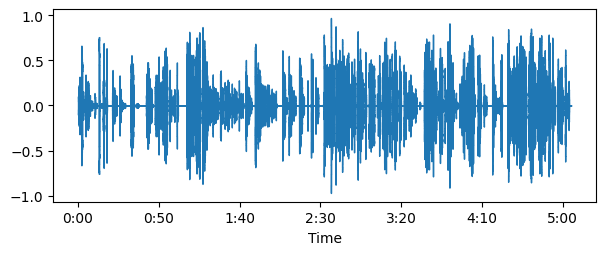

In [61]:
waveform = whisperx.load_audio(example_5_min)
vizualize_waveform(waveform)

In [71]:
whisper_model = whisperx.load_model(model_file, device)


silero_vad, utils =    torch.hub.load(repo_or_dir=silero_dir,
                               source='local',
                               model='silero_vad',
                               force_reload=True,
                               onnx=False)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils


In [102]:
align_model, metadata = whisperx.load_align_model(language_code='en', device=device)

## Loading an Audacity project

In [54]:
# print(audacity_dir)

def find_aup_file(path):
    aup_files = [f for f in os.listdir(path) if f.endswith('.aup')]
    return aup_files[0] # Assume only one file per directory

def parse_audacity_project(path_to_aup_file):
    
    with open(path_to_aup_file, 'r') as f:
        aup = BeautifulSoup(f, features="lxml-xml")
    
    root_path = os.path.split(path_to_aup_file)[:-1]
    root_path = os.path.join(*root_path)

    project = aup.find('project')
    proj_name = project.get('projname')
    data_path = os.path.join(root_path, proj_name)

    proj_imports = project.find_all('import')
    proj_files = []
    for item in proj_imports:
        filename, offset= item.get('filename'), float(item.get('offset'))
        entry = {
            'filename': filename,
            'offset': offset
        }
        proj_files.append(entry)

    
    output = {
        'project_name' : proj_name,
        'data_path': data_path,
        'files': proj_files
    }

    return output

In [56]:
path = os.path.join(audacity_dir, find_aup_file(audacity_dir))

project = parse_audacity_project(path)
pprint(project)

{'data_path': '../data/db_02-03-2023\\V8DcTChKFF_data',
 'files': [{'filename': '1-CS12_4510.ogg', 'offset': 0.0},
           {'filename': '2-Crux_4429.ogg', 'offset': 0.0},
           {'filename': '3-JadePixie_7138.ogg', 'offset': 0.0},
           {'filename': '4-IlMaximuslI_9218.ogg', 'offset': 0.0}],
 'project_name': 'V8DcTChKFF_data'}


I am using a discord bot called craig to collect my data.  It saves files with discord names included which I intend to extract.

In [41]:
def get_discord_name(filename):
    discord_name_pattern = r'.+-(.*)\..+'
    username = re.search(discord_name_pattern, filename).group(1)
    return username

## Processing a file

In [84]:
vad_segments = get_speech_timestamps(waveform, silero_vad)

In [85]:
speech_only_waveform = collect_chunks(vad_segments, torch.tensor(waveform))

In [86]:
speech_only_segments = []
current_frame = 0
for i, entry in enumerate(vad_segments):
    speech_length = entry['end'] - entry['start']
    end_frame = current_frame + speech_length
    speech_only_segments.append(
        {'start': current_frame,
         'end': end_frame
        }
        )
    current_frame = end_frame

In [100]:
# Make sure the resulting segments aligns with the audio data
assert speech_only_segments[-1]['end'] == speech_only_waveform.shape[0] and speech_only_segments[0]['start'] == 0

In [98]:
df = []
for i, (orig, short) in enumerate(zip(vad_segments, speech_only_segments)):
    df.append({
        'id': i,
        'start': orig['start'],
        'end': orig['end'],
        'short_start': short['start'],
        'short_end': short['end']
    })

df = pd.DataFrame(df)
df.head()

,id,start,end,short_start,short_end
0,0,4640,23008,0,18368
1,1,30240,56288,18368,44416
2,2,81440,90592,44416,53568
3,3,95776,107488,53568,65280
4,4,121888,150496,65280,93888


Now I have shortened waveform to feed to whisper and a map that will allow me to translate timestamps back to their original position.

In [101]:
results = whisper_model.transcribe(speech_only_waveform)

In [120]:
results['text']

" Oh my god, he's loud again. Hello Craig. Turn him down. He was down. Now he's loud again. Well that's because you broke your ears. Hello. Hello. Hello my friend. Hi. Welcome. We got a session of D&D coming up. Last time, it's kinda interesting. We all somehow lived. We have. Yeah. It is a pretty, pretty amazing thing. We got very lucky, apparently. And I guess unintentionally very well prepared. very well prepared you're right. We bought our potions, we got our supplies, we had Miley and called the ritual and then we went to a place where everything was bad. I'm not bad at it, but most of it is. We got to watch a dreamlike sequence where the inhabitants of Adam's past did like this dark ritual thing, it involved human sacrifice and then you know opened a portal to the far realm and stuff. And it basically just kind of fucked up reality in this place. But also it kind of felt like a lot of the fucked up-ness was because there was an inevitable there who was destroying and recreating t

In [103]:
result_aligned = whisperx.align(results["segments"], align_model, metadata, speech_only_waveform, device)

In [146]:
adf = pd.DataFrame(result_aligned['word_segments'])
adf[['start','end']] = (adf[['start','end']] * SAMPLING_RATE).astype(int)
adf

,text,start,end
0,Oh,0,1302
1,my,1628,2604
2,"god,",2930,5535
3,he's,6512,9117
4,loud,9768,13024
...,...,...,...
530,at,3083481,3084765
531,times.,3085728,3092471
532,Very,3100858,3104413
533,"contrary,",3105060,3113464


In [147]:
adf[(adf.start >= 0) & (adf.start < 18368)]

,text,start,end
0,Oh,0,1302
1,my,1628,2604
2,"god,",2930,5535
3,he's,6512,9117
4,loud,9768,13024
5,again.,13350,16280


In [150]:
f = lambda x: adf[(adf.start >= x['short_start']) & (adf.start < x['short_end'])]
df['word_segments'] = df.apply(f, axis=1)
df.head()

,id,start,end,short_start,short_end,word_segments
0,0,4640,23008,0,18368,text start end 0 Oh 0 130...
1,1,30240,56288,18368,44416,text start end 6 Hello 18886 24...
2,2,81440,90592,44416,53568,text start end 11 He 51866 52845 12...
3,3,95776,107488,53568,65280,text start end 13 down. 54478 56111
4,4,121888,150496,65280,93888,text start end 14 Now 66560 ...


In [165]:
f = lambda x: ' '.join(x['word_segments']['text'].to_list())
df['text'] = df.apply(f, axis=1)
df.head()

,id,start,end,short_start,short_end,word_segments,text
0,0,4640,23008,0,18368,text start end 0 Oh 0 130...,"Oh my god, he's loud again."
1,1,30240,56288,18368,44416,text start end 6 Hello 18886 24...,Hello Craig. Turn him down.
2,2,81440,90592,44416,53568,text start end 11 He 51866 52845 12...,He was
3,3,95776,107488,53568,65280,text start end 13 down. 54478 56111,down.
4,4,121888,150496,65280,93888,text start end 14 Now 66560 ...,Now he's loud again. Well that's because you b...


In [166]:
df.shape

(107, 7)

In [ ]:
# for idx, row in df.iterrows():
#     print(row['text'])
#     listen_waveform(speech_only_waveform[row['short_start']:row['short_end']])

In [173]:
adf.iloc[521]

text        It's
start    3030825
end      3035963
Name: 521, dtype: object

In [176]:
df.iloc[-4]

id                                                             103
start                                                      4688928
end                                                        4724192
short_start                                                2997824
short_end                                                  3033088
word_segments             text    start      end
515         I ...
text                        I think the narrator was helpful. It's
Name: 103, dtype: object

if word ends after segment ends, put word in next segment